In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_base = '/content/drive/MyDrive/rec_a2'

path_game_description = f'{path_base}/steam_game_description_376110.xlsx'
path_user_data = f'{path_base}/recommender_training_data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
n_recommendations = 10

# list of test user ids
test_user_ids = [1296292, 7660555, 13215940, 13978957, 6984186]

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer
import torch
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

import requests
from bs4 import BeautifulSoup
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [ ]:
def get_steam_game_title_from_id(game_id):
    try:
        url = f"https://store.steampowered.com/app/{game_id}"
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        game_title = soup.find('div', id='appHubAppName')
        if game_title:
            game_title = soup.find('div', id='appHubAppName').text.strip()
        else:
            game_title = ""
        return game_title
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the URL: {e}")
        return ""

In [ ]:
class HybridGameRecommendationEngine:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        """
        Initialize the hybrid recommendation engine with multiple models
        """
        self.bert_model = SentenceTransformer(model_name)
        self.games_df = None
        self.interactions_df = None
        self.tag_embeddings = None
        self.tag_clusters = None
        self.user_profiles = None
        self.game_tag_matrix = None
        self.tfidf_vectorizer = None

        # New attributes for collaborative filtering
        self.user_item_matrix = None
        self.user_factors = None
        self.item_factors = None
        self.user_id_map = None
        self.game_id_map = None
        self.reverse_user_map = None
        self.reverse_game_map = None

        # Model weights for hybrid approach
        self.content_weight = 0.8
        self.collab_weight = 0.2

    def load_data(self, games_file, interactions_file):
        """Load game metadata and user interactions data"""
        print("Loading data...")

        # Load games data
        self.games_df = pd.read_excel(games_file)
        self.games_df['description'] = self.games_df['description'].fillna('')
        print(f"Loaded {len(self.games_df)} games")

        # Load interactions data
        self.interactions_df = pd.read_csv(interactions_file)
        self.interactions_df['is_recommended'] = self.interactions_df['is_recommended'].map({
            True: 1, 'True': 1, 'TRUE': 1, False: 0, 'False': 0, 'FALSE': 0
        })
        print(f"Loaded {len(self.interactions_df)} interactions")

        # Filter interactions to only include games we have metadata for
        valid_games = set(self.games_df['app_id'])
        self.interactions_df = self.interactions_df[self.interactions_df['app_id'].isin(valid_games)]
        print(f"Filtered to {len(self.interactions_df)} valid interactions")

    def preprocess_tags(self):
        """Preprocess and clean game tags"""
        print("\nPreprocessing tags...")

        # Clean and split tags
        self.games_df['tag'] = self.games_df['tag'].fillna('')
        self.games_df['tags_list'] = self.games_df['tag'].fillna('').apply(
            lambda x: [tag.strip() for tag in x.split(',') if tag.strip()]
        )

        # Create a comprehensive tag vocabulary
        all_tags = []
        for tags in self.games_df['tags_list']:
            all_tags.extend(tags)

        self.tag_vocabulary = list(set(all_tags))
        print(f"Found {len(self.tag_vocabulary)} unique tags")

        # Create tag frequency analysis
        tag_counts = Counter(all_tags)
        self.popular_tags = dict(tag_counts.most_common(50))
        print(f"Most popular tags: {list(self.popular_tags.keys())[:10]}")

    def create_bert_tag_embeddings(self):
        """Create BERT embeddings for all tags and cluster them"""
        print("\nCreating BERT embeddings for tags...")

        # Generate embeddings for all tags
        self.tag_embeddings = self.bert_model.encode(self.tag_vocabulary)
        print(f"Generated embeddings with shape: {self.tag_embeddings.shape}")

        # Cluster tags using K-means
        n_clusters = min(20, len(self.tag_vocabulary) // 10)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.tag_clusters = kmeans.fit_predict(self.tag_embeddings)

        # Create tag cluster mapping
        self.tag_to_cluster = {tag: cluster for tag, cluster in zip(self.tag_vocabulary, self.tag_clusters)}

        # Display cluster examples
        cluster_examples = defaultdict(list)
        for tag, cluster in self.tag_to_cluster.items():
            cluster_examples[cluster].append(tag)

        print(f"\nGenerated {n_clusters} Tag clusters:")
        for cluster_id, tags in list(cluster_examples.items()):
            print(f"Cluster {cluster_id:02d} - Count: {len(tags):02d}: {tags[:8]}")

    def create_game_profiles(self):
        """Create game profiles based on tag clusters and TF-IDF"""
        print("\nCreating game profiles...")

        # Create cluster-based features for each game
        cluster_features = []
        game_descriptions = []

        for _, game in self.games_df.iterrows():
            # Cluster-based features
            cluster_counts = np.zeros(max(self.tag_clusters) + 1)
            for tag in game['tags_list']:
                if tag in self.tag_to_cluster:
                    cluster_counts[self.tag_to_cluster[tag]] += 1

            # Normalize by number of tags
            if len(game['tags_list']) > 0:
                cluster_counts = cluster_counts / len(game['tags_list'])

            cluster_features.append(cluster_counts)
            game_descriptions.append(' '.join(game['tags_list']))

        self.game_cluster_features = np.array(cluster_features)

        # Create TF-IDF features for tags
        self.tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words=None)
        self.game_tfidf_features = self.tfidf_vectorizer.fit_transform(game_descriptions).toarray()

        # Combine cluster and TF-IDF features
        self.game_features = np.hstack([self.game_cluster_features, self.game_tfidf_features])
        print(f"Created game profiles with {self.game_features.shape[1]} features")

    def build_collaborative_filtering_model(self, n_factors=50):
        """
        Build collaborative filtering model using matrix factorization
        """
        print("\nBuilding collaborative filtering model...")

        # Create user and game ID mappings
        unique_users = sorted(self.interactions_df['user_id'].unique())
        unique_games = sorted(self.interactions_df['app_id'].unique())

        self.user_id_map = {user_id: idx for idx, user_id in enumerate(unique_users)}
        self.game_id_map = {game_id: idx for idx, game_id in enumerate(unique_games)}
        self.reverse_user_map = {idx: user_id for user_id, idx in self.user_id_map.items()}
        self.reverse_game_map = {idx: game_id for game_id, idx in self.game_id_map.items()}

        # Create user-item matrix
        row_indices = []
        col_indices = []
        data = []

        for _, interaction in self.interactions_df.iterrows():
            if interaction['user_id'] in self.user_id_map and interaction['app_id'] in self.game_id_map:
                row_indices.append(self.user_id_map[interaction['user_id']])
                col_indices.append(self.game_id_map[interaction['app_id']])
                # Use 1 for positive, -1 for negative recommendations
                data.append(1 if interaction['is_recommended'] else -1)

        self.user_item_matrix = csr_matrix(
            (data, (row_indices, col_indices)),
            shape=(len(unique_users), len(unique_games))
        )

        print(f"Created user-item matrix with shape: {self.user_item_matrix.shape}")

        # Perform SVD for matrix factorization
        U, sigma, Vt = svds(self.user_item_matrix, k=n_factors)

        # Create factor matrices
        self.user_factors = U
        self.item_factors = Vt.T
        self.sigma = np.diag(sigma)

        print(f"Created user factors: {self.user_factors.shape}")
        print(f"Created item factors: {self.item_factors.shape}")

    def get_collaborative_recommendations(self, user_id, n_recommendations=10):
        """
        Get recommendations using collaborative filtering
        """
        if user_id not in self.user_id_map:
            return []

        user_idx = self.user_id_map[user_id]

        # Get user's latent factors
        user_vec = self.user_factors[user_idx, :].dot(self.sigma)

        # Calculate scores for all items
        scores = self.item_factors.dot(user_vec)

        # Get games user has already interacted with
        user_games = set(self.interactions_df[self.interactions_df['user_id'] == user_id]['app_id'].values)

        # Create recommendations
        recommendations = []
        for idx, score in enumerate(scores):
            game_id = self.reverse_game_map[idx]
            if game_id not in user_games and game_id in self.games_df['app_id'].values:
                game_data = self.games_df[self.games_df['app_id'] == game_id].iloc[0]
                recommendations.append({
                    'app_id': game_id,
                    'tags': game_data['tag'],
                    'score': score,
                    'description': game_data['description'][:200] + '...'
                })

        # Sort by score and return top N
        recommendations.sort(key=lambda x: x['score'], reverse=True)
        return recommendations[:n_recommendations]

    def build_user_profiles(self):
        """Build user profiles based on their interaction history"""
        print("\nBuilding user profiles...")

        # Filter positive interactions
        positive_interactions = self.interactions_df[self.interactions_df['is_recommended'] == 1]

        user_profiles = {}
        game_id_to_idx = {app_id: idx for idx, app_id in enumerate(self.games_df['app_id'])}

        for user_id in positive_interactions['user_id'].unique():
            user_games = positive_interactions[positive_interactions['user_id'] == user_id]['app_id'].values

            # Get indices of games this user liked
            game_indices = [game_id_to_idx[game_id] for game_id in user_games if game_id in game_id_to_idx]

            if len(game_indices) > 0:
                # Average the features of games this user liked
                user_profile = np.mean(self.game_features[game_indices], axis=0)
                user_profiles[user_id] = user_profile

        self.user_profiles = user_profiles
        print(f"Built profiles for {len(user_profiles)} users")

    def get_hybrid_recommendations(self, user_id, n_recommendations=10,
                                 content_weight=None, collab_weight=None):
        """
        Get hybrid recommendations combining content-based and collaborative filtering
        """
        if content_weight is None:
            content_weight = self.content_weight
        if collab_weight is None:
            collab_weight = self.collab_weight

        # Normalize weights
        total_weight = content_weight + collab_weight
        content_weight /= total_weight
        collab_weight /= total_weight

        # Get content-based recommendations
        content_recs = self.get_user_recommendations(user_id, n_recommendations=n_recommendations*3)

        # Get collaborative filtering recommendations
        collab_recs = self.get_collaborative_recommendations(user_id, n_recommendations=n_recommendations*3)

        # Combine recommendations
        game_scores = {}

        # Add content-based scores
        for rec in content_recs:
            game_scores[rec['app_id']] = content_weight * rec['similarity']

        # Add collaborative filtering scores
        for rec in collab_recs:
            if rec['app_id'] in game_scores:
                game_scores[rec['app_id']] += collab_weight * (rec['score'] / 10)  # Normalize score
            else:
                game_scores[rec['app_id']] = collab_weight * (rec['score'] / 10)

        # Get games user has already interacted with
        user_games = set(self.interactions_df[self.interactions_df['user_id'] == user_id]['app_id'].values)

        # Create final recommendations
        recommendations = []
        for game_id, score in game_scores.items():
            if game_id not in user_games and game_id in self.games_df['app_id'].values:
                game_data = self.games_df[self.games_df['app_id'] == game_id].iloc[0]
                recommendations.append({
                    'app_id': game_id,
                    'tags': game_data['tag'],
                    'hybrid_score': score,
                    'description': game_data['description'][:200] + '...'
                })

        # Sort by hybrid score and return top N
        recommendations.sort(key=lambda x: x['hybrid_score'], reverse=True)
        return recommendations[:n_recommendations]

    def get_user_recommendations(self, user_id, n_recommendations=10):
        """Get content-based recommendations for a specific user"""
        if user_id not in self.user_profiles:
            return []

        user_profile = self.user_profiles[user_id].reshape(1, -1)

        # Get games this user has already interacted with
        user_games = set(self.interactions_df[self.interactions_df['user_id'] == user_id]['app_id'].values)

        # Calculate similarity with all games
        similarities = cosine_similarity(user_profile, self.game_features)[0]

        # Get top recommendations (excluding games user has already interacted with)
        recommendations = []
        game_id_to_idx = {app_id: idx for idx, app_id in enumerate(self.games_df['app_id'])}

        for game_id, game_idx in game_id_to_idx.items():
            if game_id not in user_games:
                game_data = self.games_df.iloc[game_idx]
                recommendations.append({
                    'app_id': game_id,
                    'tags': game_data['tag'],
                    'similarity': similarities[game_idx],
                    'description': game_data['description'][:200] + '...'
                })

        # Sort by similarity and return top N
        recommendations.sort(key=lambda x: x['similarity'], reverse=True)
        return recommendations[:n_recommendations]

    def get_similar_games_by_tags(self, game_id, n_recommendations=10):
        """Get similar games based on tag similarity using BERT embeddings"""
        if game_id not in self.games_df['app_id'].values:
            return []

        game_idx = self.games_df[self.games_df['app_id'] == game_id].index[0]
        target_features = self.game_features[game_idx].reshape(1, -1)

        # Calculate similarity with all other games
        similarities = cosine_similarity(target_features, self.game_features)[0]

        # Get top similar games (excluding the game itself)
        similar_indices = np.argsort(similarities)[::-1][1:n_recommendations+1]

        recommendations = []
        for idx in similar_indices:
            game_data = self.games_df.iloc[idx]
            recommendations.append({
                'app_id': game_data['app_id'],
                'tags': game_data['tag'],
                'similarity': similarities[idx],
                'description': game_data['description'][:200] + '...'
            })

        return recommendations

    def analyze_tag_clusters(self):
        """Analyze and visualize tag clusters"""
        print("Analyzing tag clusters...")

        # Reduce dimensionality for visualization
        pca = PCA(n_components=2, random_state=42)
        tag_embeddings_2d = pca.fit_transform(self.tag_embeddings)

        # Create visualization
        plt.figure(figsize=(6, 4))
        scatter = plt.scatter(tag_embeddings_2d[:, 0], tag_embeddings_2d[:, 1],
                            c=self.tag_clusters, cmap='tab20', alpha=0.7)

        # Add labels for some popular tags
        popular_tag_indices = [i for i, tag in enumerate(self.tag_vocabulary)
                              if tag in list(self.popular_tags.keys())[:20]]

        for i in popular_tag_indices:
            plt.annotate(self.tag_vocabulary[i],
                        (tag_embeddings_2d[i, 0], tag_embeddings_2d[i, 1]),
                        fontsize=8, alpha=0.8)

        plt.title('BERT-based Tag Clusters Visualization')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.colorbar(scatter)
        plt.tight_layout()
        plt.show()

    def compare_recommendation_methods(self, user_id):
        """Compare different recommendation methods for a user"""
        print(f"\n=== COMPARING RECOMMENDATION METHODS FOR USER {user_id} ===")

        # Get user history
        user_games = set(self.interactions_df[self.interactions_df['user_id'] == user_id]['app_id'].values)
        print(f"\nUser History ({len(user_games)} games):")

        count = 1
        for game_id in list(user_games)[:n_recommendations]:
            game_info = self.games_df[self.games_df['app_id'] == game_id]
            if not game_info.empty:
                print(f"{count}. Game {game_id}: {get_steam_game_title_from_id(game_id)}")
                # Safely get the tag and convert to string before slicing
                game_tag_raw = game_info.iloc[0]['tag']
                game_tag = str(game_tag_raw) if pd.notna(game_tag_raw) else ''
                if game_tag:
                    print(f"   Tags: {game_tag}...")
                else:
                    print(f"   Tags: ...")
                count += 1

        # Content-based recommendations
        print(f"\n--- CONTENT-BASED RECOMMENDATIONS ---")
        content_recs = self.get_user_recommendations(user_id, n_recommendations=5)
        for i, rec in enumerate(content_recs, 1):
            print(f"{i}. Game {rec['app_id']}: {get_steam_game_title_from_id(rec['app_id'])}")
            print(f"   Tags: {rec['tags']}...")
            print(f"   Similarity: {rec['similarity']:.2f}")

        # Collaborative filtering recommendations
        print(f"\n--- COLLABORATIVE FILTERING RECOMMENDATIONS ---")
        collab_recs = self.get_collaborative_recommendations(user_id, n_recommendations=5)
        for i, rec in enumerate(collab_recs, 1):
            print(f"{i}. Game {rec['app_id']}: {get_steam_game_title_from_id(rec['app_id'])}")
            print(f"   Tags: {rec['tags']}...")
            print(f"   Score: {rec['score']:.2f}")

        # Hybrid recommendations
        print(f"\n--- HYBRID RECOMMENDATIONS (50/50 blend) ---")
        hybrid_recs = self.get_hybrid_recommendations(user_id, n_recommendations=5)
        for i, rec in enumerate(hybrid_recs, 1):
            print(f"{i}. Game {rec['app_id']}: {get_steam_game_title_from_id(rec['app_id'])}")
            print(f"   Tags: {rec['tags']}...")
            print(f"   Hybrid Score: {rec['hybrid_score']:.2f}")

    def fit(self, games_file, interactions_file):
        """Complete pipeline to build the hybrid recommendation system"""
        print("=== Building Hybrid Game Recommendation Engine ===")

        # Load and preprocess data
        self.load_data(games_file, interactions_file)
        self.preprocess_tags()

        # Create BERT-based tag embeddings and clusters
        self.create_bert_tag_embeddings()

        # Build game and user profiles for content-based filtering
        self.create_game_profiles()
        self.build_user_profiles()

        # Build collaborative filtering model
        self.build_collaborative_filtering_model(n_factors=50)

        print("\n\n=== Hybrid Recommendation Engine Ready! ===")

=== Building Hybrid Game Recommendation Engine ===
Loading data...
Loaded 37610 games
Loaded 1007681 interactions
Filtered to 1007681 valid interactions

Preprocessing tags...
Found 446 unique tags
Most popular tags: ['Indie', 'Singleplayer', 'Adventure', 'Action', 'Casual', '2D', 'Simulation', 'Strategy', 'Atmospheric', 'RPG']

Creating BERT embeddings for tags...
Generated embeddings with shape: (446, 384)

Generated 20 Tag clusters:
Cluster 06 - Count: 26: ['Rome', 'Cult Classic', 'Gothic', 'Psychological Horror', 'Supernatural', 'Demons', 'Dark Comedy', 'Dark Fantasy']
Cluster 09 - Count: 25: ['Gaming', 'RPGMaker', 'Trading Card Game', 'LEGO', 'Gambling', 'Steam Machine', 'Mahjong', 'Singleplayer']
Cluster 07 - Count: 18: ['Interactive Fiction', 'Story Rich', 'Visual Novel', 'Investigation', 'Multiple Endings', 'Narrative', 'Feature Film', 'Dynamic Narration']
Cluster 08 - Count: 34: ['Turn-Based Combat', 'Grand Strategy', 'Battle Royale', 'Combat', 'Warhammer 40K', 'Turn-Based Tac

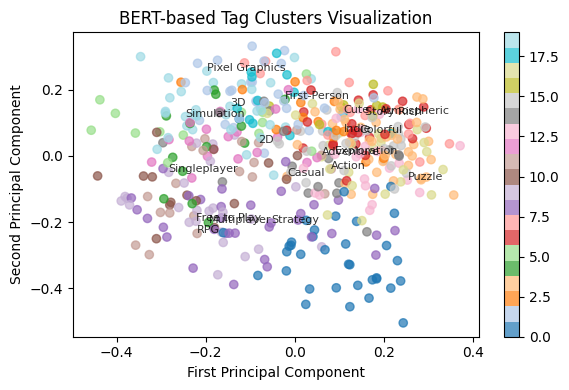

In [ ]:
# Initialize the hybrid recommendation engine
hybrid_recommender = HybridGameRecommendationEngine()

# Build the recommendation system
hybrid_recommender.fit(path_game_description, path_user_data)

# Analyze tag clusters
hybrid_recommender.analyze_tag_clusters()

In [ ]:
# Compare different recommendation methods for test users
for test_user_id in test_user_ids:
    hybrid_recommender.compare_recommendation_methods(test_user_id)


=== COMPARING RECOMMENDATION METHODS FOR USER 1296292 ===

User History (2 games):
1. Game 262060: Darkest Dungeon®
   Tags: Turn-Based Combat, Dark Fantasy, Dungeon Crawler, Roguelike, RPG, Lovecraftian, Difficult, Turn-Based, Singleplayer, Perma Death, Strategy, Atmospheric, Dark, Indie, 2D, Roguelite, Horror, Gothic, Fantasy, Kickstarter...
2. Game 1203220: NARAKA: BLADEPOINT
   Tags: Battle Royale, Multiplayer, Martial Arts, Mature, PvP, Action, Female Protagonist, Character Customization, Massively Multiplayer, Fighting, Survival, Third Person, Swordplay, Hack and Slash, Anime, Parkour, Adventure, Free to Play, Violent, Gore...

--- CONTENT-BASED RECOMMENDATIONS ---
1. Game 807120: Iratus: Lord of the Dead
   Tags: RPG, Strategy, Indie, Turn-Based Combat, Roguelike, Villain Protagonist, Dark Fantasy, Roguelite, Dark, Turn-Based, Turn-Based Tactics, Lovecraftian, Fantasy, 2D, Difficult, Gothic, Replay Value, Dungeon Crawler, Violent, Gore...
   Similarity: 0.74
2. Game 738760: the

In [ ]:
# Example of game-based recommendation
print("\n\n=== CONTENT-BASED GAME SIMILARITY ===")
sample_game = hybrid_recommender.games_df['app_id'].iloc[random.randint(1, 100)]

print(f"\nSimilar games to {sample_game}: {get_steam_game_title_from_id(sample_game)}")
similar_games = hybrid_recommender.get_similar_games_by_tags(sample_game, n_recommendations=n_recommendations)
for i, rec in enumerate(similar_games, 1):
    print(f"{i}. Game {rec['app_id']}: {get_steam_game_title_from_id(rec['app_id'])}")
    print(f"   Tags: {rec['tags'][:100]}...")
    print(f"   Similarity: {rec['similarity']:.2f}")

# Experiment with different weight combinations
print("\n\n=== EXPERIMENTING WITH DIFFERENT WEIGHT COMBINATIONS ===")
weight_combinations = [(0.8, 0.2), (0.5, 0.5), (0.2, 0.8)]

# Compare different recommendation methods for test users
for test_user_id in test_user_ids:
    hybrid_recommender.compare_recommendation_methods(test_user_id)

    for content_w, collab_w in weight_combinations:
        print(f"\nHybrid Recommendations for User {test_user_id} (Content: {content_w}, Collaborative: {collab_w}):")
        hybrid_recs = hybrid_recommender.get_hybrid_recommendations(
            test_user_id, n_recommendations=n_recommendations,
            content_weight=content_w, collab_weight=collab_w
        )
        for i, rec in enumerate(hybrid_recs, 1):
            print(f"{i}. Game {rec['app_id']}: {get_steam_game_title_from_id(rec['app_id'])}")
            print(f"   Hybrid Score: {rec['hybrid_score']:.2f}")



=== CONTENT-BASED GAME SIMILARITY ===

Similar games to 8870: 
1. Game 311210: Call of Duty®: Black Ops III
   Tags: Gore...
   Similarity: 1.00
2. Game 41000: Serious Sam HD: The First Encounter
   Tags: Gore...
   Similarity: 1.00
3. Game 339340: Resident Evil 0
   Tags: Gore...
   Similarity: 1.00
4. Game 21090: F.E.A.R.
   Tags: Gore...
   Similarity: 1.00
5. Game 390340: Umbrella Corps
   Tags: Gore...
   Similarity: 1.00
6. Game 222480: Resident Evil Revelations
   Tags: Gore...
   Similarity: 1.00
7. Game 594650: Hunt: Showdown 1896
   Tags: Gore...
   Similarity: 1.00
8. Game 361700: 
   Tags: Gore...
   Similarity: 1.00
9. Game 274290: Gods Will Be Watching
   Tags: Gore...
   Similarity: 1.00
10. Game 304240: Resident Evil
   Tags: Gore...
   Similarity: 1.00


=== EXPERIMENTING WITH DIFFERENT WEIGHT COMBINATIONS ===

=== COMPARING RECOMMENDATION METHODS FOR USER 1296292 ===

User History (2 games):
1. Game 262060: Darkest Dungeon®
   Tags: Turn-Based Combat, Dark Fantasy, 